In [1]:
import warnings
warnings.filterwarnings("ignore")

## Let's first understand how to generate n-grams using CountVectorizer

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 5, 'hathodawala': 1, 'is': 2, 'looking': 4, 'for': 0, 'job': 3}

In [3]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 9,
 'hathodawala': 2,
 'is': 4,
 'looking': 7,
 'for': 0,
 'job': 6,
 'thor hathodawala': 10,
 'hathodawala is': 3,
 'is looking': 5,
 'looking for': 8,
 'for job': 1}

In [4]:
v = CountVectorizer(ngram_range=(1,3))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 12,
 'hathodawala': 2,
 'is': 5,
 'looking': 9,
 'for': 0,
 'job': 8,
 'thor hathodawala': 13,
 'hathodawala is': 3,
 'is looking': 6,
 'looking for': 10,
 'for job': 1,
 'thor hathodawala is': 14,
 'hathodawala is looking': 4,
 'is looking for': 7,
 'looking for job': 11}

- We will not take a simple collection of text documents, preprocess them to remove stop words, lemmatize etc and then generate bag of 1 grams and 2 grams from it

In [5]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [6]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

2023-04-17 15:30:02.717905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 15:30:03.387718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
preprocess("Thor ate pizza")


'thor eat pizza'

In [8]:
preprocess("Loki is eating pizza")


'Loki eat pizza'

In [9]:
corpus_processed = [
    preprocess(text) for text in corpus
]
corpus_processed

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [10]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

In [11]:
v.transform(["Thor eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]])

## Let's take a document that has out of vocabulary (OOV) term and see how bag of ngram generates vector out of it

In [12]:
v.transform(["Hulk eat pizza"]).toarray()


array([[1, 1, 0, 0, 0, 1, 0, 0, 0]])

News Category Classification Problem
Okay now that we know basics of BAG of n grams vectorizer 😎 It is the time to work on a real problem. Here we want to do a news category classification. We will use bag of n-grams and traing a machine learning model that can categorize any news into one of the following categories,

1. BUSINESS
2. SPORTS
3. CRIME
4. SCIENCE

#### DataSet
- This data consists of two columns. - Text - Category
- Text is a news article
- Category can be one of these 4: 'BUSINESS', 'SPORTS', 'CRIME', 'SCIENCE', to keep things simple I trimmed additional categories from the original dataset

In [13]:
import pandas as pd

df = pd.read_json('news_dataset.json')
print(df.shape)

df.head()

(12695, 2)


,text,category
0,"Watching Schrödinger's Cat Die University of California, Berkeley, physicists have, for the first time, showed that, in fact, it's possible to follow the metaphorical cat through the whole process, whether he lives or dies in the end.",SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,"Entrepreneurs Today Don't Need a Big Budget to Start It wasn't so many years ago that starting a new e-commerce business on the Internet was a complex custom development project, usually costing a million dollars or more. Now you can do it for free.",BUSINESS
3,These Roads Could Recharge Your Electric Car As You Drive The high-tech highways just might change the game for EV road trips.,BUSINESS
4,"Civilian 'Guard' Fires Gun While 'Protecting' Recruiting Center Volunteer civilian ""guards"" have been kicked off the grounds outside a military recruiting center in Lancaster, Ohio, after",CRIME


In [14]:
df.category.value_counts()

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64

## Handle class imbalance

- I will use undersampling technique here.

In [15]:
min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class


df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2022)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2022)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2022)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2022)


In [16]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()


BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: category, dtype: int64

- Convert text category to a number

In [17]:
target = {'BUSINESS': 0, 'SPORTS': 1, 'CRIME': 2, 'SCIENCE': 3}

df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1, 
    'CRIME': 2, 
    'SCIENCE': 3
})

In [18]:
df_balanced.head()

,text,category,category_num
11967,"GCC Business Leaders Remain Confident in the Face of Regional Challenges The success of the economies of these countries is not only important for their own people, but for the millions of expatriates who work there, sometimes under difficult circumstances, and who annually send $50 billion to their home countries -- making this region the largest source of remittances in the world.",BUSINESS,0
2912,"From the Other Side; an Honest Review from Employees Whether we wake up in the mornings loving what we do or not, it is important to remember the people we come in contact with during our day-to-day activities are trying to make a living for themselves and their families as well.",BUSINESS,0
3408,"Mike McDerment, CEO of FreshBooks, Talks About Almost Giving Up So why do you build a product? Do you do it for money? Fame? Bragging rights? In the case of Mike McDerment, CEO of FreshBooks, you do it because you see there is a problem with the current convention.",BUSINESS,0
502,"How to Market Your Business While Traveling the World I was recently on an amazing cruise with my wife in the Caribbean. During this time, I was forced to work on cruise Wi-Fi as well as internet hotspots. I was able to live the life I wanted while traveling the world... all while marketing my company online. It actually grew ten percent while I was gone.",BUSINESS,0
5279,"How to Leverage Intuition in Decision-making It may feel safer to rely on logic or the opinions of others, but your gut instinct isn't just a willy-nilly mush of emotions, it's the sum of the subtle information that your brain has collected, but hasn't yet fully processed. It's your own inner wisdom.",BUSINESS,0


### Build a model with original text (no pre processing)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)
print(X_train.shape)
X_train.head()

(4419,)


7589     Ovulating Women Prefer Images of Penetration O...
10442    Scientists Discover Spooky Influence On Baby N...
8792     Olympic Race Walker Steps Up To Propose To His...
1733     Beloved Bipedal Bear Named Pedals Believed Kil...
2526     Elizabeth Smart Gave Birth To Baby Girl, Fathe...
Name: text, dtype: object

In [20]:
y_train.value_counts()

3    1105
2    1105
0    1105
1    1104
Name: category_num, dtype: int64

In [21]:
y_test.value_counts()

1    277
0    276
3    276
2    276
Name: category_num, dtype: int64

## Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



In [23]:
X_test[:5]


3716     African Nation Slaps Exxon With Fine Nearly 7 ...
608      These Cringe-Worthy Stories Show It Can Be Har...
11172    LISTEN: The Accidental Discovery That Proved T...
1346     Build Loyalty -- The Cost -- $00.00 Remember y...
1356     Man Killed By Michigan Police Wasn't Targeting...
Name: text, dtype: object

In [24]:

y_pred[:5]

array([0, 3, 3, 0, 2])

In [25]:

y_test[:5]

3716     0
608      3
11172    3
1346     0
1356     2
Name: category_num, dtype: int64

## Attempt 2 : Use 1-gram and bigrams

In [26]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_1_2_gram', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



## Attempt 3 : Use 1-gram to trigrams

In [27]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_1_3_grams', CountVectorizer(ngram_range = (1, 3))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       276
           1       0.96      0.73      0.83       277
           2       0.83      0.87      0.85       276
           3       0.93      0.76      0.83       276

    accuracy                           0.82      1105
   macro avg       0.84      0.82      0.82      1105
weighted avg       0.84      0.82      0.82      1105



### Use text pre-processing to remove stop words, punctuations and apply lemmatization
You may wonder, we have not done any text-processing yet to remove stop words, punctuations, apply lemmatization etc. Well we wanted to train the model without any preprocessing first and check the performance. Now we will re-do same thing but with preprocessing of text

In [28]:
df_balanced['preprocessed_txt'] = df_balanced['text'].apply(preprocess) 
df_balanced.head()

,text,category,category_num,preprocessed_txt
11967,"GCC Business Leaders Remain Confident in the Face of Regional Challenges The success of the economies of these countries is not only important for their own people, but for the millions of expatriates who work there, sometimes under difficult circumstances, and who annually send $50 billion to their home countries -- making this region the largest source of remittances in the world.",BUSINESS,0,GCC Business Leaders remain Confident Face Regional Challenges success economy country important people million expatriate work difficult circumstance annually send $ 50 billion home country make region large source remittance world
2912,"From the Other Side; an Honest Review from Employees Whether we wake up in the mornings loving what we do or not, it is important to remember the people we come in contact with during our day-to-day activities are trying to make a living for themselves and their families as well.",BUSINESS,0,Honest Review employee wake morning love important remember people come contact day day activity try living family
3408,"Mike McDerment, CEO of FreshBooks, Talks About Almost Giving Up So why do you build a product? Do you do it for money? Fame? Bragging rights? In the case of Mike McDerment, CEO of FreshBooks, you do it because you see there is a problem with the current convention.",BUSINESS,0,Mike McDerment ceo FreshBooks Talks give build product money fame bragging right case Mike McDerment ceo FreshBooks problem current convention
502,"How to Market Your Business While Traveling the World I was recently on an amazing cruise with my wife in the Caribbean. During this time, I was forced to work on cruise Wi-Fi as well as internet hotspots. I was able to live the life I wanted while traveling the world... all while marketing my company online. It actually grew ten percent while I was gone.",BUSINESS,0,market business travel World recently amazing cruise wife Caribbean time force work cruise Wi Fi internet hotspot able live life want travel world market company online actually grow percent go
5279,"How to Leverage Intuition in Decision-making It may feel safer to rely on logic or the opinions of others, but your gut instinct isn't just a willy-nilly mush of emotions, it's the sum of the subtle information that your brain has collected, but hasn't yet fully processed. It's your own inner wisdom.",BUSINESS,0,Leverage intuition decision making feel safe rely logic opinion gut instinct willy nilly mush emotion sum subtle information brain collect fully process inner wisdom


## Build a model with pre processed text

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_txt, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)
print(X_train.shape)
X_train.head()

(4419,)


7589     ovulate woman prefer Images Penetration Images...
10442     scientist Discover Spooky Influence Baby Choices
8792     Olympic Race Walker step Propose Boyfriend Rio...
1733     Beloved Bipedal Bear name Pedals believe kill ...
2526       Elizabeth Smart give Birth Baby Girl Father say
Name: preprocessed_txt, dtype: object

In [30]:
y_train.value_counts()

3    1105
2    1105
0    1105
1    1104
Name: category_num, dtype: int64

In [31]:
y_test.value_counts()

1    277
0    276
3    276
2    276
Name: category_num, dtype: int64

In [32]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       276
           1       0.92      0.82      0.87       277
           2       0.83      0.92      0.87       276
           3       0.90      0.81      0.85       276

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.86      0.86      0.86      1105



- If you compare above classification report for (1,2) gram with the one from unprocessed text, you will find some improvement in the model that uses preprocessed cleaned up text. Hence we can conclude that for this particular problem using preprocessing (removing stop words, lemmatization) is improving the performance of the model

# Plot Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[243,   8,  17,   8],
       [ 10, 228,  29,  10],
       [ 15,   2, 253,   6],
       [ 36,   9,   7, 224]])

Text(95.72222222222221, 0.5, 'Truth')

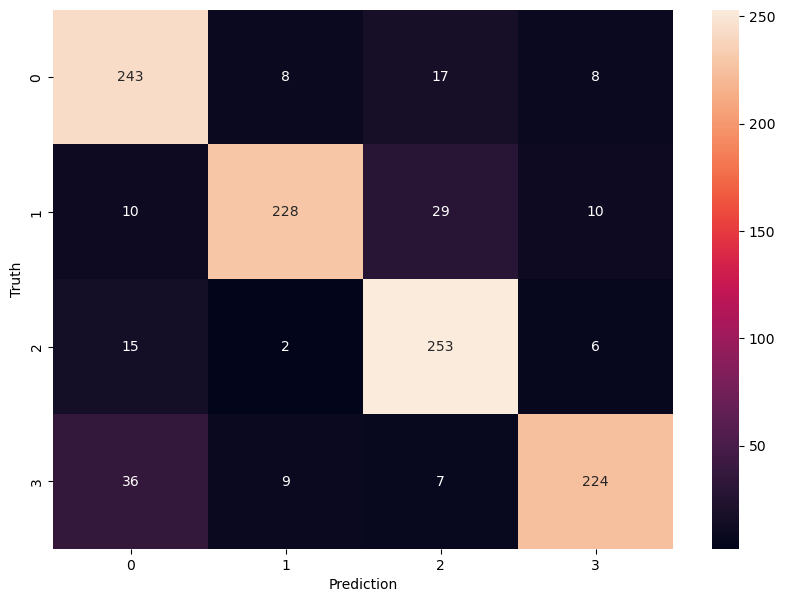

In [34]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# Exercise 

In [35]:
import pandas as pd


#read the dataset with name "Fake_Real_Data.csv" and store it in a variable df
df = pd.read_csv("Fake_Real_Data.csv")

#print the shape of dataframe
print(df.shape)

#print top 5 rows
df.head(5)

(9900, 2)


Text label
0   Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake
1  U.S. conservative leader optimistic of common ...  Real
2  Trump proposes U.S. tax overhaul, stirs concer...  Real
3   Court Forces Ohio To Allow Millions Of Illega...  Fake
4  Democrats say Trump agrees to work on immigrat...  Real

In [36]:
#check the distribution of labels 
df['label'].value_counts()

Fake    5000
Real    4900
Name: label, dtype: int64

- From the above, we can see that almost the labels(classes) occured equal number of times and balanced. There is no problem of class imbalance and hence no need to apply any balancing techniques like undersampling, oversampling etc.

In [37]:
#Add the new column which gives a unique number to each of these labels 

df['label_num'] = df['label'].map({'Fake' : 0, 'Real': 1})

#check the results with top 5 rows
df.head(5)

Text label  label_num
0   Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake          0
1  U.S. conservative leader optimistic of common ...  Real          1
2  Trump proposes U.S. tax overhaul, stirs concer...  Real          1
3   Court Forces Ohio To Allow Millions Of Illega...  Fake          0
4  Democrats say Trump agrees to work on immigrat...  Real          1

# Modelling without Pre-processing Text data


In [38]:
from sklearn.model_selection import train_test_split


#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(
    df.Text, 
    df.label_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.label_num
)


In [39]:
#print the shapes of X_train and X_test

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (7920,)
Shape of X_test:  (1980,)


## Attempt 1 :

- using sklearn pipeline module create a classification pipeline to classify the Data.

- using CountVectorizer with unigram, bigram, and trigrams.
- use KNN as the classifier with n_neighbors of 10 and metric as 'euclidean' distance.
- print the classification report.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from  sklearn.neighbors import KNeighborsClassifier

#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_trigrams', CountVectorizer(ngram_range = (1, 3))),                   #using the ngram_range parameter 
     ('KNN', (KNeighborsClassifier(n_neighbors=10, metric = 'euclidean')))           #using the KNN classifier with 10 neighbors and euclidean distance      
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.49      0.65      1000
           1       0.65      0.98      0.78       980

    accuracy                           0.73      1980
   macro avg       0.81      0.74      0.72      1980
weighted avg       0.81      0.73      0.72      1980



## Attempt 2 :

- using CountVectorizer with unigram, bigram, and trigrams.
- use KNN as the classifier with n_neighbors of 10 and metric as 'cosine' distance.
- print the classification report.

In [41]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_trigrams', CountVectorizer(ngram_range = (1, 3))),          #using the ngram_range parameter 
     ('KNN', (KNeighborsClassifier(n_neighbors = 10, metric = 'cosine')))    #using the KNN classifier with 10 neighbors and cosine distance       
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.55      0.71      1000
           1       0.69      1.00      0.81       980

    accuracy                           0.77      1980
   macro avg       0.84      0.77      0.76      1980
weighted avg       0.84      0.77      0.76      1980



Attempt 3 :
    
- using CountVectorizer with only trigrams.
- use RandomForest as the classifier.
- print the classification report.

In [42]:
from sklearn.ensemble import RandomForestClassifier


#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_n_grams', CountVectorizer(ngram_range = (3, 3))),                       #using the ngram_range parameter 
    ('random_forest', (RandomForestClassifier()))         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1000
           1       0.98      1.00      0.99       980

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



## Attempt 4 :

- using CountVectorizer with both unigram and bigrams.
- use Multinomial Naive Bayes as the classifier with an alpha value of 0.75.
- print the classification report.

In [43]:
from sklearn.naive_bayes import MultinomialNB


#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_trigrams', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB(alpha = 0.75))         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.98      0.99       980

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



# Use text pre-processing to remove stop words, punctuations and apply lemmatization

In [44]:
#use this utility function to get the preprocessed text data

import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [45]:
# create a new column "preprocessed_txt" and use the utility function above to get the clean data
# this will take some time, please be patient
df['preprocessed_txt'] = df['Text'].apply(preprocess) 

In [46]:
#print the top 5 rows
df.head()

Text label  label_num  \
0   Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake          0   
1  U.S. conservative leader optimistic of common ...  Real          1   
2  Trump proposes U.S. tax overhaul, stirs concer...  Real          1   
3   Court Forces Ohio To Allow Millions Of Illega...  Fake          0   
4  Democrats say Trump agrees to work on immigrat...  Real          1   

                                    preprocessed_txt  
0    Trump Surrogate BRUTALLY Stabs Pathetic vide...  
1  U.S. conservative leader optimistic common gro...  
2  trump propose U.S. tax overhaul stir concern d...  
3    Court Forces Ohio allow million illegally pu...  
4  Democrats Trump agree work immigration bill wa...

## Build a model with pre processed text

In [47]:
#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
#Note: Make sure to use only the "preprocessed_txt" column for splitting

X_train, X_test, y_train, y_test = train_test_split(
    df.preprocessed_txt, 
    df.label_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.label_num
)

# Attempt1 :

- using CountVectorizer with only trigrams.
- use RandomForest as the classifier.
- print the classification report.

In [48]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_n_grams', CountVectorizer(ngram_range = (3, 3))),                       #using the ngram_range parameter 
    ('random_forest', (RandomForestClassifier()))         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1000
           1       0.99      0.93      0.96       980

    accuracy                           0.96      1980
   macro avg       0.96      0.96      0.96      1980
weighted avg       0.96      0.96      0.96      1980



## Attempt2 :

- using CountVectorizer with unigram, bigram, and trigrams.
- use RandomForest as the classifier.
- print the classification report.

In [49]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_n_grams', CountVectorizer(ngram_range = (1, 3))),                       #using the ngram_range parameter 
    ('random_forest', (RandomForestClassifier()))         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00       980

    accuracy                           1.00      1980
   macro avg       1.00      1.00      1.00      1980
weighted avg       1.00      1.00      1.00      1980



Text(95.72222222222221, 0.5, 'Truth')

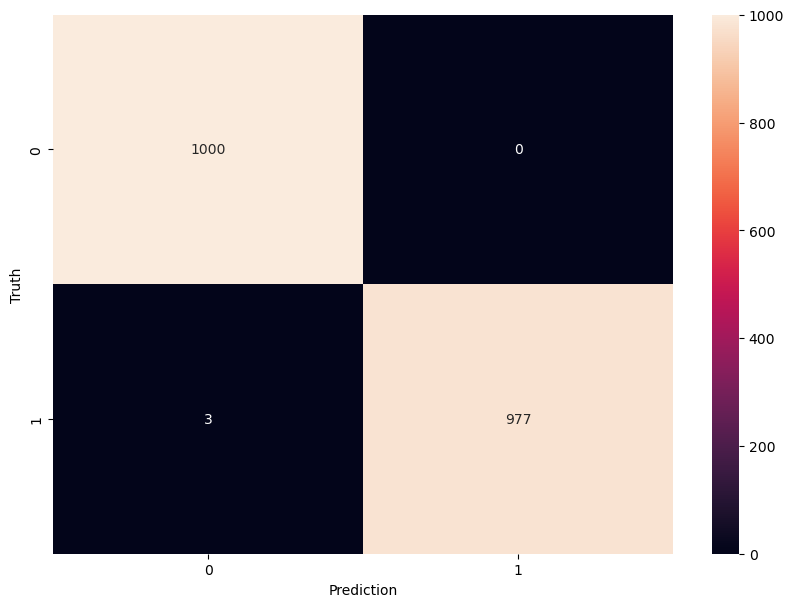

In [50]:
#finally print the confusion matrix for the best model

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# Final Observations

## Without Pre-Processing Data

- From the above in most of the cases, we can see that when we have the count vectorizer above trigrams or at trigrams, the performance keeps degrading. The major possible reason for this as the ngram_range keeps increasing, the number of dimensions/features (possible combination of words) also increases enormously and models have the risk of overfitting and resulting in terrible performance.

- For this reason, models like KNN failed terribly when performed with trigrams and using the euclidean distance. K-Nearest Neighbours(KNN) doesn't work well with high-dimensional data because, with a large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension. In higher dimensional space, the cost to calculate distance becomes expensive and hence impacts the performance of the model. It performed well for class 1 and had terrible results for Class 0.

- Both recall and F1 scores increase better when trained with the same KNN model but with cosine distance as cosine distance does not get influenced by the number of dimensions as it uses the angle better the two text vectors to calculate the similarity.

- With respect to Naive and RandomForest models, both performed really well, and random forest with trigrams has a better edge on the recall metric.

- As Random Forest uses Bootstrapping(row and column Sampling) with many decision trees and overcomes the high variance and overfitting of high dimensional data and also uses feature importance of words for better classifying the categories.

- The easy calculation of probabilities for the words in the corpus(Bag of words) and storing them in a contingency table is the major reason for the Multinomial NaiveBayes to be a text classification friendly algorithm.

## With Pre-Processing Data

- Have trained the best model RandomForest on the pre-processed data, but RandomForest with trigrams fails to produce the same results here.

- But the same randomForest with Unigram to Trigram features helps to produce very amazing results and is tops in the entire list with very good F1 scores and Recall scores.

# END